In [4]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
from matplotlib import pyplot as plt 
from scipy.stats import norm
from sklearn.gaussian_process.kernels import RBF
from scipy.optimize import minimize
from scipy.stats import qmc
from scipy.special import erfinv
from scipy.stats.qmc import MultivariateNormalQMC
from scipy.stats import skew


The below class fits a Gaussian process mopdel to a sample redshift distribution using a Radial Basis Function kernel.

The model is fit by minimising the _cost function with quasi-random samples.

The Sobol sampling technique generates more uniformly distributed quasi-random sequences. Good for moments fitting, bad for MCMC.

In [5]:
class PZErrorRBFModel(object): 
    from sklearn.gaussian_process.kernels import RBF
    def __init__(self, nz, z_grid, std_mean_goal, num_samp=2**15): 
        """
        nz: numpy array, Sample Redshift Distribution histogram heights
        z_grid: numpy array, Midpoints corresponding to the Sample Redshift Distribuiton historam heights
        num_samp: integer, Number of samples to generate during method of moments fitting, should be power of 2
        std_mean_goal: double, Standard deviation on the mean of the sample redshift distribution log-gp process to be fitted
        
        """
        self.fid_pz = nz
        self.midpoints = z_grid 
        self.num_samp = num_samp
        self.std_mean_goal = std_mean_goal

    def fit_log_gp_model(self, par_ini=np.sqrt(np.array([0.02, 0.05]))):
    
        res = minimize(self._cost, par_ini, method='Nelder-Mead')
        return res
        
    def quasi_random_sample(self, par, num_samp): 
        """ Using Quasi Random Sampler --> num_samp should be power of 2
        It's QUASI RANDOM sampling using Sobol squences, good for fitting method of moments but under no 
        circumstances to be used in an MCMC!!! 
        
        """
        kernel = par[0]**2 * RBF(par[1]**2)
        cov = kernel(np.column_stack((self.midpoints, self.midpoints)))
        log_gp = MultivariateNormalQMC(mean = np.log(self.fid_pz+np.nextafter(np.float32(0), np.float32(1))), cov=cov)
        samples = np.exp(log_gp.random(num_samp))
        samples = np.array([el/np.trapz(el, self.midpoints) for el in samples])
        return samples
    
    def _cost(self, par):
        samples = self.quasi_random_sample(par, self.num_samp)
        mean_list = np.array([np.trapz(el*self.midpoints, self.midpoints) for el in samples])
        res = (np.std(mean_list) - self.std_mean_goal)**2 
    
        return res

Demonstrate using Mock Data
----------------

In [71]:
data = np.random.normal(1.0, 0.5, size=10000) 

grid = np.linspace(0.1, 3.0, 50)
midpoints = grid[:-1] + (grid[1] - grid[0])/0.5
pdf_true = np.histogram(data, grid)[0]
pz = pdf_true/np.trapz(pdf_true, midpoints)
model = PZErrorRBFModel(pz, midpoints, 0.01, num_samp=2**10)
res = model.fit_log_gp_model()
print('Result: ')
print(res)
                                                          

Result: 
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.1590104609043637e-14
             x: [ 1.243e-01  2.205e-01]
           nit: 23
          nfev: 54
 final_simplex: (array([[ 1.243e-01,  2.205e-01],
                       [ 1.242e-01,  2.206e-01],
                       [ 1.243e-01,  2.205e-01]]), array([ 4.159e-14,  3.929e-12,  2.881e-09]))


True Mean:  1.1300773046159345


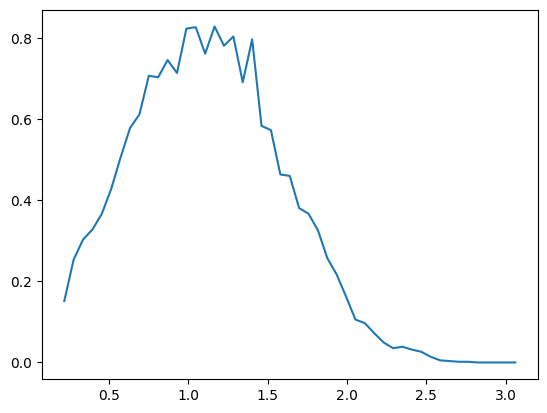

In [81]:
plt.plot(midpoints, pz, label='True P(z)')
true_mean = np.trapz(pz*midpoints, midpoints)
print('True Mean: ', true_mean)

Visualize
----------

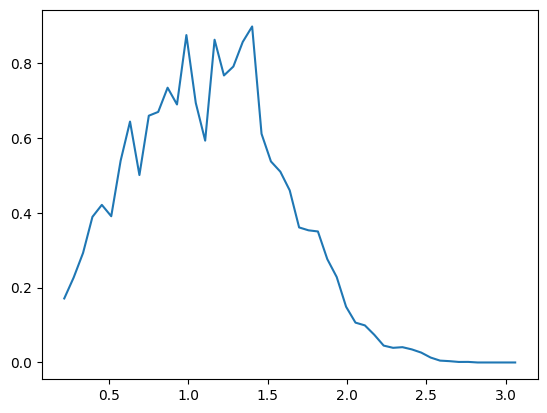

In [85]:
qrand_sample = model.quasi_random_sample(res.x, 2**10)
plt.plot(midpoints, qrand_sample[4])

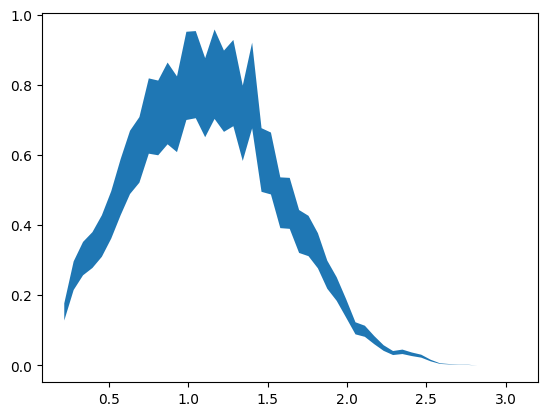

In [76]:
plt.fill_between(midpoints, np.percentile(qrand_sample, 10, axis=0), np.percentile(qrand_sample, 90, axis=0))

(array([ 0.65193817,  0.        ,  0.        ,  0.        ,  0.        ,
         0.65193817,  0.        ,  1.30387634,  0.65193817,  1.30387634,
         1.95581452,  3.91162903,  1.95581452,  1.95581452,  6.51938172,
         5.86744355,  8.47519623, 13.03876343, 16.95039246, 19.55814515,
        21.51395967, 26.07752687, 35.20466127, 41.72404299, 35.85659944,
        36.50853761, 39.76822847, 38.46435213, 28.03334138, 37.81241396,
        39.1162903 , 30.64109407, 24.12171235, 26.07752687, 28.03334138,
        24.12171235, 21.51395967, 12.38682526,  9.1271344 ,  6.51938172,
         5.21550537,  8.47519623,  1.95581452,  0.65193817,  2.60775269,
         0.        ,  0.65193817,  0.        ,  0.        ,  0.65193817]),
 array([-0.04116511, -0.03966717, -0.03816923, -0.0366713 , -0.03517336,
        -0.03367542, -0.03217749, -0.03067955, -0.02918161, -0.02768367,
        -0.02618574, -0.0246878 , -0.02318986, -0.02169192, -0.02019399,
        -0.01869605, -0.01719811, -0.01570017, -0

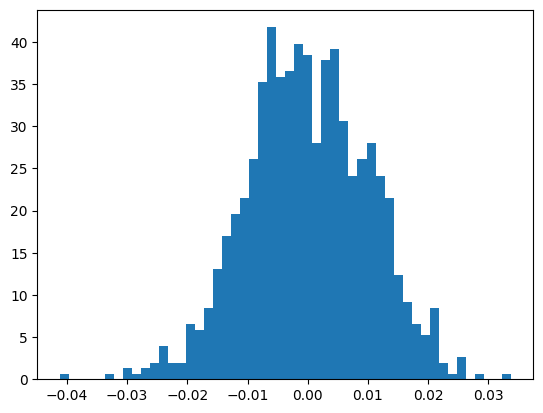

In [90]:
shifts = []
for sample in qrand_sample: 
    mean = np.trapz(sample*midpoints, midpoints)
    shifts.extend([mean-true_mean])

plt.hist(shifts, bins=50, density=True)